In [1]:
import os

# Use the eager mode
os.environ['PT_HPU_LAZY_MODE'] = '0'

# Verify the environment variable is set
print(f"PT_HPU_LAZY_MODE: {os.environ['PT_HPU_LAZY_MODE']}")

import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# import habana_frameworks.torch.core as htcore

PT_HPU_LAZY_MODE: 0
2.4.0+cpu


In [2]:
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx

## Data Handling in PyG

### Data

Let's create a dummy graph

In [3]:
# use rich traceback

from rich import traceback
traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f03b5e2fd00>>

In [4]:
device = torch.device("cpu")

In [5]:
embeddings = torch.rand((100, 16), dtype=torch.float, device=device)

In [6]:
rows = np.random.choice(100, 500)
cols = np.random.choice(100, 500)
edges = torch.tensor([rows, cols], device=device, dtype=torch.long)

/tmp/ipykernel_2520741/688213010.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edges = torch.tensor([rows, cols], device=device, dtype=torch.long)


In [7]:
edges_attr = np.random.choice(3,500)

In [8]:
ys = torch.rand((100), device=device).round().long()

Convert the graph information into a PyG Data object

In [9]:
graph = data.Data(x=embeddings, edge_index=edges, edge_attr=edges_attr, y=ys)

In [10]:
graph

Data(x=[100, 16], edge_index=[2, 500], edge_attr=[500], y=[100])

Let's visualize the information contained in the data object

In [11]:
for prop in graph:
    print(prop)

('x', tensor([[0.2389, 0.5205, 0.0142,  ..., 0.9251, 0.9804, 0.7271],
        [0.1468, 0.8484, 0.8652,  ..., 0.6395, 0.2699, 0.4810],
        [0.2951, 0.6959, 0.9258,  ..., 0.9556, 0.3036, 0.7087],
        ...,
        [0.1812, 0.3925, 0.9182,  ..., 0.6010, 0.0861, 0.1197],
        [0.7583, 0.7928, 0.3235,  ..., 0.0064, 0.0162, 0.6892],
        [0.6153, 0.2400, 0.2377,  ..., 0.2843, 0.8505, 0.0624]]))
('edge_index', tensor([[47, 95, 86, 24, 21, 59,  6, 42, 47, 37, 85, 40, 47, 47, 16, 43, 75, 81,
         31, 13, 43, 92, 99,  8, 70, 28, 49, 35, 37, 74, 34,  0, 59, 27, 31, 59,
         65, 86,  8, 77, 98, 22, 39, 31, 20, 77, 56, 29, 24, 48, 53, 38, 10, 95,
         41,  1, 71, 89, 52, 40,  5, 22, 80, 49, 57, 18, 71, 80, 39, 43, 89, 17,
         27, 70, 61, 17, 14,  7, 45, 58, 35, 61, 76, 91, 21, 30, 38, 14, 34, 63,
         57, 35, 79, 40, 81, 94, 16, 44, 28, 31, 73, 56, 52, 49, 68,  4, 25, 48,
         81,  2, 21, 73,  1, 49, 58, 36, 93,  0, 41,  9, 46, 54, 70,  9, 16, 53,
         80, 

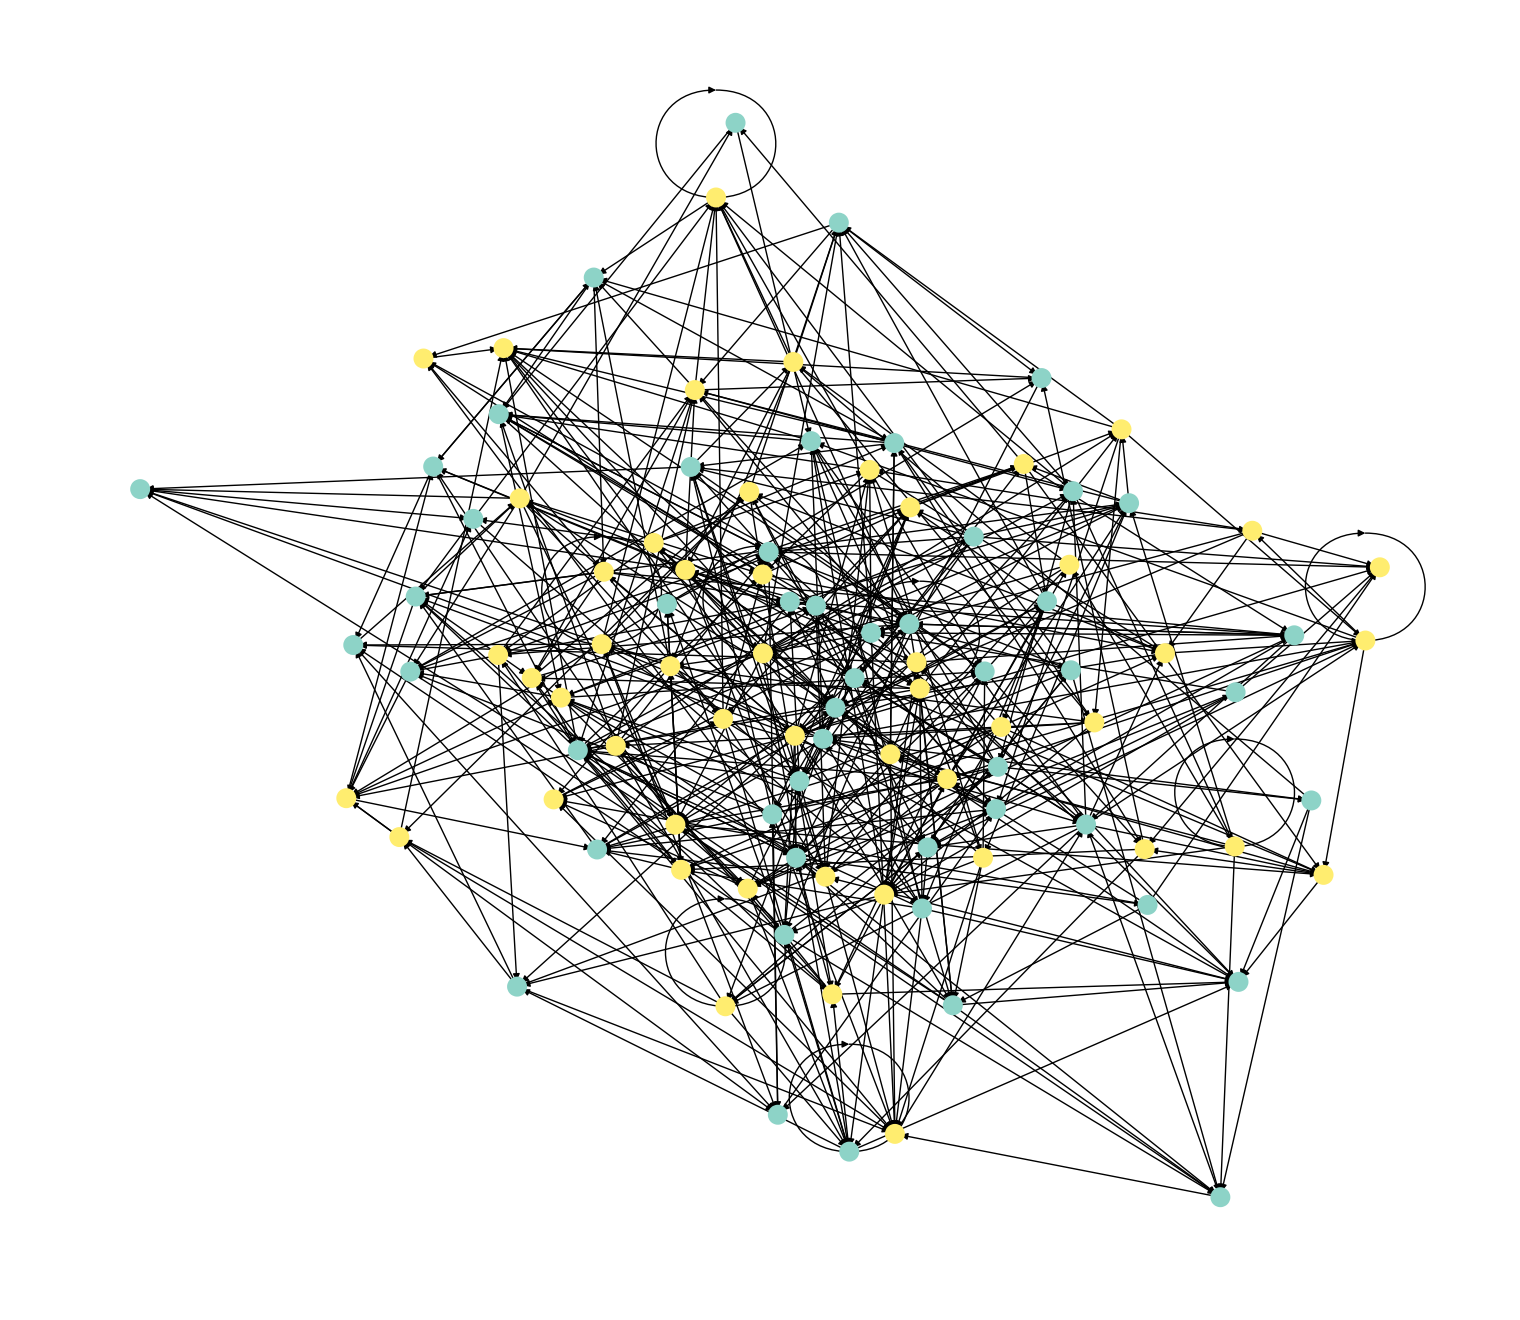

In [12]:
vis = to_networkx(graph)

node_labels = graph.y.cpu().numpy()

import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,13)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=70,linewidths=6)
plt.show()

### Batch

With the Batch object we can represent multiple graphs as a single disconnected graph

In [13]:
graph2 = graph

In [14]:
batch = data.Batch().from_data_list([graph, graph2])

In [15]:
print("Number of graphs:",batch.num_graphs)
print("Graph at index 1:",batch[1])
print("Retrieve the list of graphs:\n",len(batch.to_data_list()))

Number of graphs: 2
Graph at index 1: Data(x=[100, 16], edge_index=[2, 500], edge_attr=[500], y=[100])
Retrieve the list of graphs:
 2


### Cluster

ClusterData groups the nodes of a graph into a specific number of cluster for faster computation in large graphs, then use ClusterLoader to load batches of clusters

In [16]:
cluster = data.ClusterData(graph, 5)

/root/pyg_cpu/pyg_cpu/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.ClusterData' is deprecated, use 'loader.ClusterData' instead
  warnings.warn(out)
Computing METIS partitioning...
Done!


In [17]:
clusterloader = data.ClusterLoader(cluster)

/root/pyg_cpu/pyg_cpu/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.ClusterLoader' is deprecated, use 'loader.ClusterLoader' instead
  warnings.warn(out)


### Sampler

For each convolutional layer, sample a maximum of nodes from each neighborhood (as in GraphSAGE)

In [18]:
sampler = data.NeighborSampler(graph.edge_index, sizes=[3,10], batch_size=4,
                                  shuffle=False)

/root/pyg_cpu/pyg_cpu/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.NeighborSampler' is deprecated, use 'loader.NeighborSampler' instead
  warnings.warn(out)


In [19]:
for s in sampler:
    print(s)
    break

(4, tensor([ 0,  1,  2,  3, 28, 30, 36, 27, 39, 14,  6, 94, 93, 79, 49, 35, 80, 26,
         9, 58, 96, 68, 32, 11, 10,  5, 90, 81, 60, 40, 31, 75, 62, 61, 57, 34,
        29,  4, 77, 70, 33, 53, 24, 20, 59, 42, 37, 21, 13,  8, 92]), [EdgeIndex(edge_index=tensor([[ 4,  4,  5, 14, 15,  3,  6,  7, 16, 17, 18,  8,  9, 10, 19, 11, 12, 13,
          4, 20, 21, 22, 23, 24, 25, 12,  1, 16, 26, 27, 28, 29, 30, 30,  7, 31,
         32, 32, 33, 34, 35, 35, 36, 37,  7, 21, 38, 39, 40, 19, 41, 21, 31, 39,
         17, 33, 37, 42, 43, 15, 18, 43, 44, 45, 46, 47, 48, 49, 14, 17, 21, 30,
         30, 31, 50],
        [ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,
          4,  4,  4,  4,  4,  4,  4,  5,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10,
         11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13,
         13, 13, 13]]), e_id=tensor([ 98, 212, 423, 355,  80, 283, 480,  3

In [20]:
print("Batch size:", s[0])
print("Number of unique nodes involved in the sampling:",len(s[1]))
print("Number of neighbors sampled:", len(s[2][0].edge_index[0]), len(s[2][1].edge_index[0]))

Batch size: 4
Number of unique nodes involved in the sampling: 51
Number of neighbors sampled: 75 12


### Datasets

List all the available datasets

In [21]:
datasets.__all__

['KarateClub',
 'TUDataset',
 'GNNBenchmarkDataset',
 'Planetoid',
 'NELL',
 'CitationFull',
 'CoraFull',
 'Coauthor',
 'Amazon',
 'PPI',
 'Reddit',
 'Reddit2',
 'Flickr',
 'Yelp',
 'AmazonProducts',
 'QM7b',
 'QM9',
 'MD17',
 'ZINC',
 'AQSOL',
 'MoleculeNet',
 'PCQM4Mv2',
 'Entities',
 'RelLinkPredDataset',
 'GEDDataset',
 'AttributedGraphDataset',
 'MNISTSuperpixels',
 'FAUST',
 'DynamicFAUST',
 'ShapeNet',
 'ModelNet',
 'CoMA',
 'SHREC2016',
 'TOSCA',
 'PCPNetDataset',
 'S3DIS',
 'GeometricShapes',
 'BitcoinOTC',
 'GDELTLite',
 'ICEWS18',
 'GDELT',
 'WILLOWObjectClass',
 'PascalVOCKeypoints',
 'PascalPF',
 'SNAPDataset',
 'SuiteSparseMatrixCollection',
 'WordNet18',
 'WordNet18RR',
 'FB15k_237',
 'WikiCS',
 'WebKB',
 'WikipediaNetwork',
 'HeterophilousGraphDataset',
 'Actor',
 'UPFD',
 'GitHub',
 'FacebookPagePage',
 'LastFMAsia',
 'DeezerEurope',
 'GemsecDeezer',
 'Twitch',
 'Airports',
 'LRGBDataset',
 'MalNetTiny',
 'OMDB',
 'PolBlogs',
 'EmailEUCore',
 'LINKXDataset',
 'Elliptic

In [23]:
# https://stackoverflow.com/questions/67064190/attributeerror-in-torch-geometric-transforms
transforms.AddTrainValTestMask = transforms.RandomNodeSplit

name = 'Cora'
transform = transforms.Compose([
    transforms.AddTrainValTestMask('train_rest', num_val=500, num_test=500),
    transforms.TargetIndegree(),
])
cora = datasets.Planetoid('./data', name, pre_transform=transforms.NormalizeFeatures(), transform=transform)

In [24]:
aids = datasets.TUDataset(root="./data", name="AIDS")

In [25]:
print("AIDS info:")
print('# of graphs:', len(aids))
print('# Classes (graphs)', aids.num_classes)
print('# Edge features', aids.num_edge_features)
print('# Edge labels', aids.num_edge_labels)
print('# Node features', aids.num_node_features)

AIDS info:
# of graphs: 2000
# Classes (graphs) 2
# Edge features 3
# Edge labels 3
# Node features 38


In [26]:
print("Cora info:")
print('# of graphs:', len(cora))
print('# Classes (nodes)', cora.num_classes)
print('# Edge features', cora.num_edge_features)
print('# Node features', cora.num_node_features)

Cora info:
# of graphs: 1
# Classes (nodes) 7
# Edge features 1
# Node features 1433


In [27]:
aids.data

/root/pyg_cpu/pyg_cpu/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[31385, 38], edge_index=[2, 64780], edge_attr=[64780, 3], y=[2000])

In [28]:
aids[0]

Data(edge_index=[2, 106], x=[47, 38], edge_attr=[106, 3], y=[1])

In [29]:
cora.data

/root/pyg_cpu/pyg_cpu/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [30]:
cora[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_attr=[10556, 1])

In [31]:
cora_loader = data.DataLoader(cora)

/root/pyg_cpu/pyg_cpu/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [32]:
for l in cora_loader:
    print(l)
    break

DataBatch(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_attr=[10556, 1], batch=[2708], ptr=[2])
